# An example to fit NHPP

## Install required packages

To install only packages that are not installed, use the following code:

In [ ]:
targetpack <- c("readr", "ggplot2","Rcpp", "dplyr", "rgl", "misc3d", "RcppArmadillo", "roptim", "plotly", "scatterplot3d")
installedpack <- installed.packages()
for(p in targetpack){
  if( !(p %in% installedpack[,"Package"]) ){
    install.packages(p)
  }
}
for(p in targetpack){
  library(p, character.only = TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘htmlwidgets’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘later’, ‘lazyeval’, ‘crosstalk’, ‘promises’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”
Warning message:


## Compile the C++ code for Maximum Likelihood Estimation

In [ ]:
sourceCpp("intensity_logis.cpp") #パスを変える

## Load the dataset

In [ ]:
brain_SMA <- read_csv("brain_SMA_sample.csv")
brain_VE <- read_csv("brain_VE_sample.csv")

Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): X, Y, Z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): X, Y, Z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Scaling the data

You can scale the values of the data if necessary. We used min-max normalization.

In [ ]:
make01mat <- function(X){
  X <- as.matrix(X)
  maxpp <- apply(X, 2, max)
  minpp <- apply(X, 2, min)
  Tau <- maxpp - minpp
  out <- sweep(sweep(X, 2, minpp, "-"), 2, Tau, "/")
  return(out)
}
ppmat_SMA <- make01mat(brain_SMA)
ppmat_VE <- make01mat(brain_VE)

Perform maximum likelihood estimation.　This process will take some time.

In [ ]:
opt_SMA <- intensity_est_logis_bfgs(ppmat_SMA[,1], ppmat_SMA[,2], ppmat_SMA[,3], c(1,1,1), numeric(4))

The value of `convergence` returns 0 if the optimization converged.

In [ ]:
print(opt_SMA)

$par
          [,1]
[1,] -9.777761
[2,]  3.075159
[3,]  3.794198
[4,]  3.475015

$value
[1] -417078.5

$convergence
[1] 0



In [ ]:
opt_VE <- intensity_est_logis_bfgs(ppmat_VE[,1], ppmat_VE[,2], ppmat_VE[,3], c(1,1,1), numeric(4))

In [ ]:
print(opt_VE)

$par
          [,1]
[1,] -9.716544
[2,]  3.074294
[3,]  3.512824
[4,]  3.479221

$value
[1] -373457.4

$convergence
[1] 0



# Plot 3d

There are several options for plotting 3d data.

Here we use scatterplot3d.

First, calculate the intensity for each points to plot.

In [ ]:
a_s <- exp(opt_SMA$par[1])
b_s <- exp(opt_SMA$par[2:4])
a_v <- exp(opt_VE$par[1])
b_v <- exp(opt_VE$par[2:4])
xv <- seq(0,1,by=0.01)
yv <- seq(0,1,by=0.01)
zv <- seq(0,1,by=0.1)
grd <- expand.grid(xv,yv,zv)
lambda_s <- numeric(nrow(grd))
lambda_v <- numeric(nrow(grd))
pb <- txtProgressBar(max = nrow(grd),style = 3)
for(i in 1:nrow(grd)){
  lambda_s[i] <- sum(a_s*prod(b_s)*d3logis((grd[i,1]-ppmat_SMA[,1]), (grd[i,2]-ppmat_SMA[,2]), (grd[i,3]-ppmat_SMA[,3]), 
    b_s[1], b_s[2], b_s[3]))
  lambda_v[i] <- sum(a_v*prod(b_v)*d3logis((grd[i,1]-ppmat_VE[,1]),(grd[i,2]-ppmat_VE[,2]),(grd[i,3]-ppmat_VE[,3]), 
    b_v[1], b_v[2], b_v[3]))
  setTxtProgressBar(pb,i)
}

  |======================================================================| 100%

In [ ]:
df_s <- data.frame(grd, intensity=lambda_s)
head(df_s)
tail(df_s)

Var1 Var2 Var3 intensity   
1 0.00 0    0    4.801809e+40
2 0.01 0    0    3.866925e+40
3 0.02 0    0    3.114057e+40
4 0.03 0    0    2.507768e+40
5 0.04 0    0    2.019520e+40
6 0.05 0    0    1.626332e+40

Var1 Var2 Var3 intensity  
112206 0.95 1    1    0.026274687
112207 0.96 1    1    0.021159159
112208 0.97 1    1    0.017039594
112209 0.98 1    1    0.013722084
112210 0.99 1    1    0.011050475
112211 1.00 1    1    0.008899012

In [ ]:
df_v <- data.frame(grd, intensity=lambda_v)
head(df_v)
tail(df_v)

Var1 Var2 Var3 intensity   
1 0.00 0    0    7.809194e+35
2 0.01 0    0    6.289967e+35
3 0.02 0    0    5.066295e+35
4 0.03 0    0    4.080680e+35
5 0.04 0    0    3.286811e+35
6 0.05 0    0    2.647383e+35

Var1 Var2 Var3 intensity  
112206 0.95 1    1    0.020560659
112207 0.96 1    1    0.016560717
112208 0.97 1    1    0.013338938
112209 0.98 1    1    0.010743935
112210 0.99 1    1    0.008653773
112211 1.00 1    1    0.006970238

In [ ]:
df_s <- data.frame(grd, intensity=lambda_s)
head(df_s)
tail(df_s)

Var1 Var2 Var3 intensity   
1 0.00 0    0    4.801809e+40
2 0.01 0    0    3.866925e+40
3 0.02 0    0    3.114057e+40
4 0.03 0    0    2.507768e+40
5 0.04 0    0    2.019520e+40
6 0.05 0    0    1.626332e+40

Var1 Var2 Var3 intensity  
112206 0.95 1    1    0.026274687
112207 0.96 1    1    0.021159159
112208 0.97 1    1    0.017039594
112209 0.98 1    1    0.013722084
112210 0.99 1    1    0.011050475
112211 1.00 1    1    0.008899012

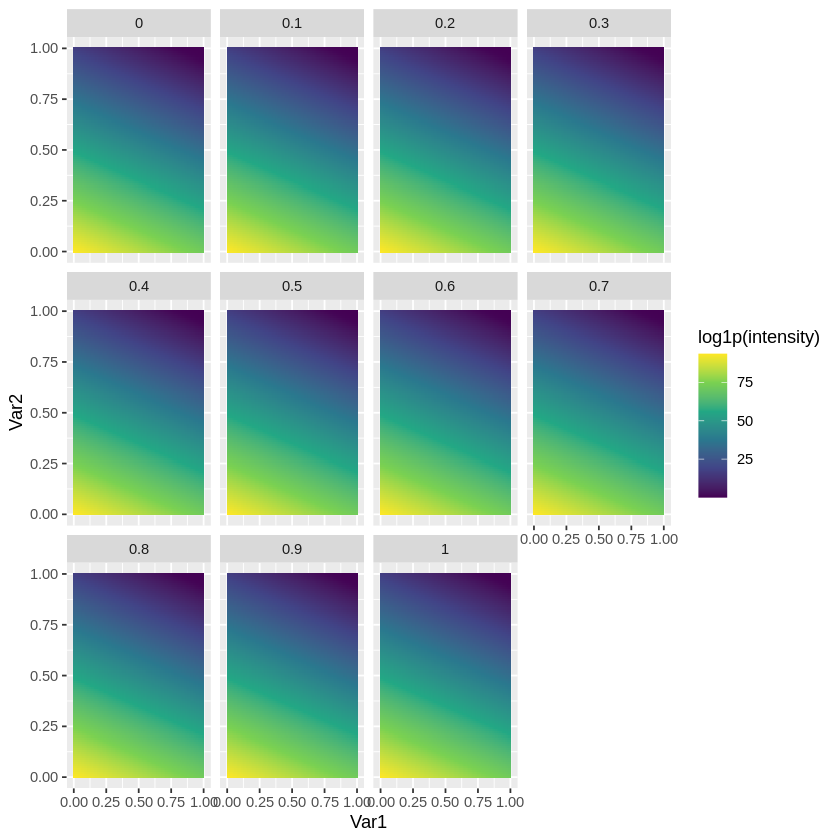

In [ ]:
ggplot(df_s, aes(x=Var1, y=Var2, fill=log1p(intensity)))+
  geom_tile()+facet_wrap(~Var3)+scale_fill_viridis_c()

In [ ]:
plot_ly(x=df_s$Var1, y=df_s$Var2, z=df_s$Var3, color=log1p(df_s$intensity), type="scatter3d", mode="markers")

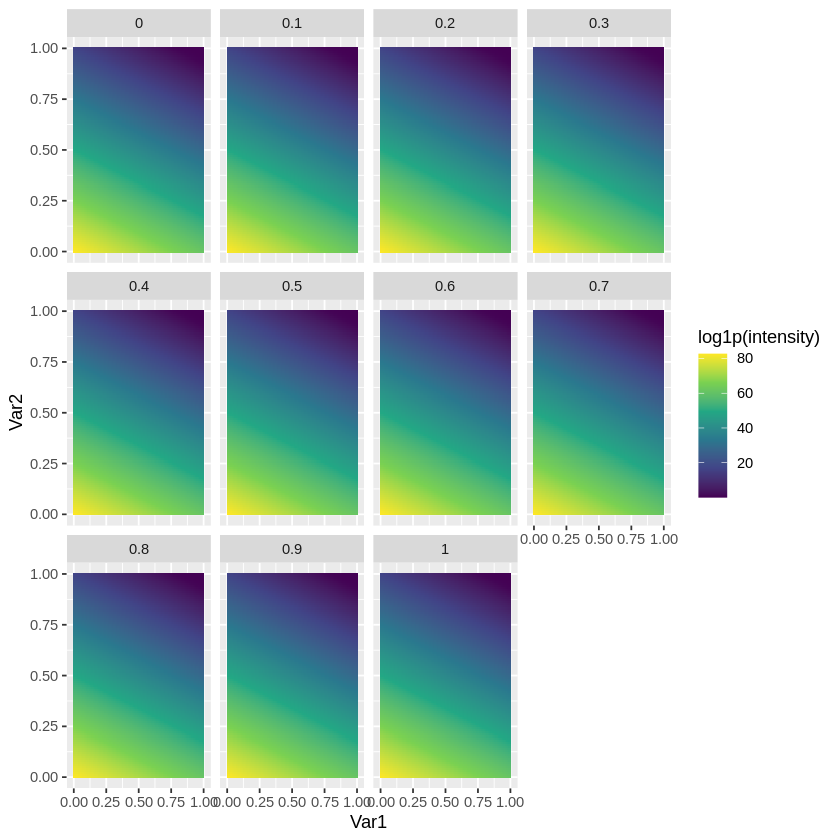

In [ ]:
ggplot(df_v, aes(x=Var1, y=Var2, fill=log1p(intensity)))+
  geom_tile()+facet_wrap(~Var3)+scale_fill_viridis_c()

Scales the intensity to map to the color palette.

In [ ]:
cols = colorRamp(c("#0080ff","white","#ff8000"))
vi <- log1p(df_v$intensity)
vi <- vi/(max(vi))

vs <- log1p(df_s$intensity)
vs <- vs/(max(vs))

You can see the intensity of each part.

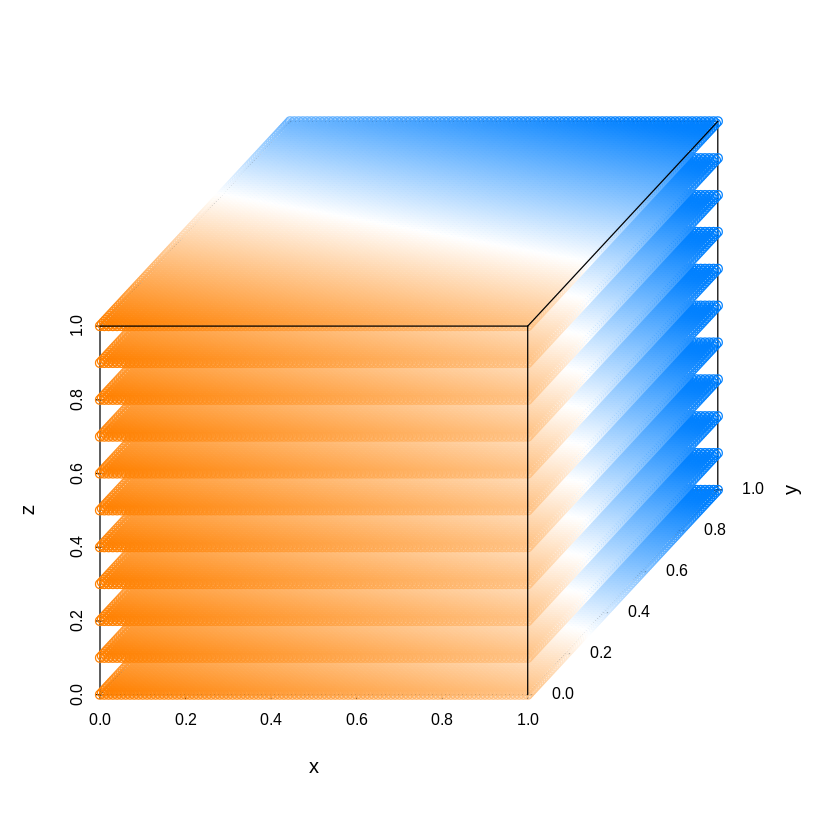

In [ ]:
scatterplot3d(x = df_v$Var1, y = df_v$Var2, z = df_v$Var3, color = rgb(cols(vi)/255), angle = 50, xlab = "x", ylab = "y", zlab = "z")

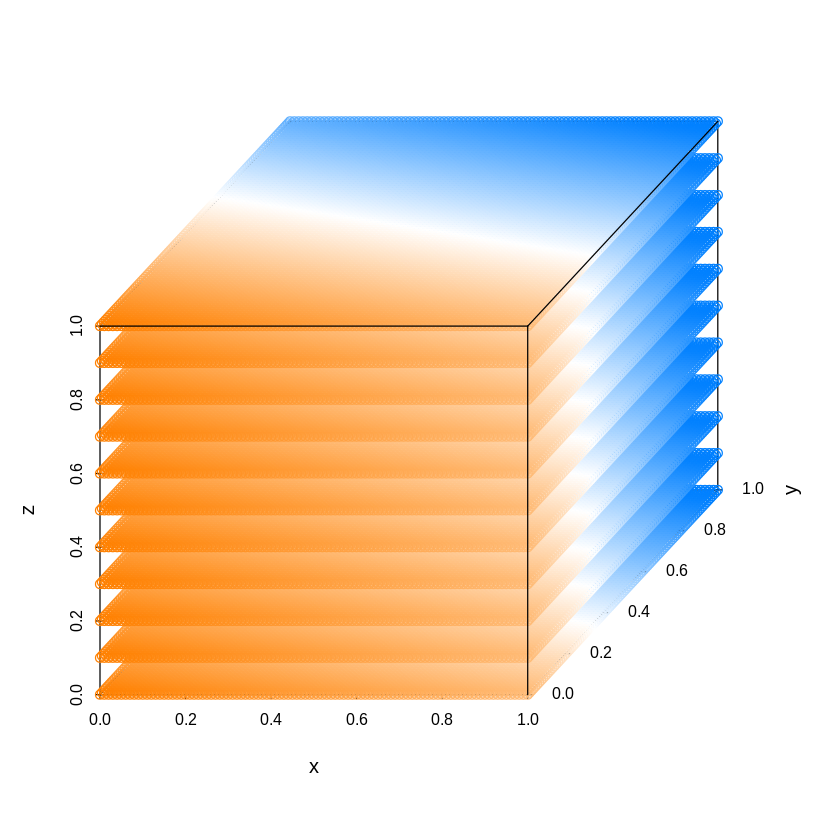

In [ ]:
scatterplot3d(x = df_s$Var1, y = df_s$Var2, z = df_s$Var3, color = rgb(cols(vs)/255), angle = 50, xlab = "x", ylab = "y", zlab = "z")